## glaucoma_retinal_analysis

In this notebook, I'll try to predict glaucoma cases with various deep-learning network configurations.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2
import os
import pandas as pd
import seaborn as sns
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import backend as K
import numpy 



In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. EDA

Let's take a look at the data first.

In [ ]:
def dataset_dimensions():
    '''Gives an outline of the dataset's dimensions'''
    base_dir = '/content/drive/MyDrive/practica_DL_UOC_2022'
    print('1. Folder by folder:')
    train = 0
    test = 0
    validation = 0
    normal = 0
    abnormal = 0
    # Folder classification
    for i in range(10):
        foldname = 'Fold' + str(i)
        print('Folder name: ' + foldname)
        train_dir_normal = os.path.join(base_dir, foldname ,'train', 'normal')
        train_dir_abnormal = os.path.join(base_dir, foldname ,'train', 'abnormal')
        test_dir_normal = os.path.join(base_dir, foldname ,'test', 'normal')
        test_dir_abnormal = os.path.join(base_dir, foldname ,'test', 'abnormal')
        validation_dir_normal = os.path.join(base_dir, foldname, 'valid', 'normal')
        validation_dir_abnormal = os.path.join(base_dir, foldname, 'valid', 'abnormal')
        dirs = {'train_dir_normal' : train_dir_normal, 'train_dir_abnormal': train_dir_abnormal, 
                    'test_dir_normal': test_dir_normal, 'test_dir_abnormal': test_dir_abnormal, 
                    'validation_dir_normal': validation_dir_normal, 'validation_dir_abnormal': validation_dir_abnormal}
    # Image count
        for type, dir in dirs.items():
            count = 0
            filelist = os.listdir(dir)
            count = len(filelist)
            if (type == 'train_dir_normal'):
                train += count
                normal += count
                div = 'train - normal eyes'
            if (type == 'test_dir_normal'):
                test += count
                normal += count
                div = 'test - normal eyes'
            if (type == 'validation_dir_normal'):
                validation += count
                normal += count
                div = 'validation - normal eyes'
            if (type == 'train_dir_abnormal'):
                train += count
                abnormal += count
                div = 'train - abnormal eyes'
            if (type == 'test_dir_abnormal'):
                test += count
                abnormal += count
                div = 'test - abnormal eyes'
            if (type == 'validation_dir_abnormal'):
                validation += count
                abnormal += count
                div = 'validation - abnormal eyes'
    # Output messages
            print('Pictures division ' + div + ': ' + str(count))
        print('__________________________')
    print('__________________________')
    print('2. Total size:')
    print('Train images: ' + str(train))
    print('Test images: ' + str(test))
    print('Validation images: ' + str(validation))
    print('__________________________')
    print('__________________________')
    print('3. Eye health:')
    print('Normal eyes: ' + str(normal))
    print('Abnormal eyes: ' + str(abnormal))



In [ ]:
dataset_dimensions()

1. Folder by folder:
Folder name: Fold0
Pictures division train - normal eyes: 754
Pictures division train - abnormal eyes: 625
Pictures division test - normal eyes: 82
Pictures division test - abnormal eyes: 92
Pictures division validation - normal eyes: 83
Pictures division validation - abnormal eyes: 71
__________________________
Folder name: Fold1
Pictures division train - normal eyes: 740
Pictures division train - abnormal eyes: 639
Pictures division test - normal eyes: 91
Pictures division test - abnormal eyes: 83
Pictures division validation - normal eyes: 88
Pictures division validation - abnormal eyes: 66
__________________________
Folder name: Fold2
Pictures division train - normal eyes: 739
Pictures division train - abnormal eyes: 640
Pictures division test - normal eyes: 97
Pictures division test - abnormal eyes: 77
Pictures division validation - normal eyes: 83
Pictures division validation - abnormal eyes: 71
__________________________
Folder name: Fold3
Pictures division 

Now, we need to make sure the information is stored into a dictionary.

In [ ]:
def folders_to_dict(n):
    '''Enters the information from the base drive directory into a dictionary'''
    base_dir = '/content/drive/MyDrive/practica_DL_UOC_2022'
    newdict = {}
    for i in range(n):
        foldname = 'Fold' + str(i)
        train_dir_normal = os.path.join(base_dir, foldname ,'train', 'normal')
        train_dir_abnormal = os.path.join(base_dir, foldname ,'train', 'abnormal')
        test_dir_normal = os.path.join(base_dir, foldname ,'test', 'normal')
        test_dir_abnormal = os.path.join(base_dir, foldname ,'test', 'abnormal')
        validation_dir_normal = os.path.join(base_dir, foldname, 'valid', 'normal')
        validation_dir_abnormal = os.path.join(base_dir, foldname, 'valid', 'abnormal')
        dirs = {'train_dir_normal' : train_dir_normal, 'train_dir_abnormal': train_dir_abnormal, 
                    'test_dir_normal': test_dir_normal, 'test_dir_abnormal': test_dir_abnormal, 
                    'validation_dir_normal': validation_dir_normal, 'validation_dir_abnormal': validation_dir_abnormal}
        for dir in dirs.values():
            newdict[dir] = []
    for foldername in newdict.keys():
        pics = os.listdir(foldername)
        for pic in pics:
            newdict[foldername].append(cv2.imread(os.path.join(foldername, pic)))
      # Every foldername completed will be printed to monitor the progress
        print(foldername)
    return newdict
            

In [ ]:
data = folders_to_dict(10)

/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/train/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/train/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/test/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/test/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/valid/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold0/valid/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/train/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/train/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/test/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/test/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/valid/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold1/valid/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold2/train/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold2/train/abnormal
/content/drive/MyDrive/practica_DL_UOC_2022/Fold2/test/normal
/content/drive/MyDrive/practica_DL_UOC_2022/Fo

Now, let's monitor the size of the images present in the dataset.

In [ ]:
def images_sizes():
    '''Checks the images' sizes and returns a description of them'''
    sizes_dic = {}
    for item_list in data.values():
        for item in item_list:
            shape = str(item.shape)
            if shape not in sizes_dic.keys():
                sizes_dic[shape] = 1
            else:
                sizes_dic[shape] += 1
    return(sizes_dic)

In [ ]:
sizes = images_sizes()
print(sizes)

{'(224, 224, 3)': 17070}


Note how there only is an image size (224, 224, 3). Let's visualize a sample.

In [ ]:
def image_show_5(division, folder):
    '''Shows a sample of every division of the imagery available'''
    base_path = '/content/drive/MyDrive/practica_DL_UOC_2022'
    target_key = os.path.join(base_path, folder, division)
    count = 0
    pics_data = []
    tit = 'First 5 pictures of the division ' + division + ' of folder ' + folder
    for pic in data[target_key]:
        pics_data.append(pic)
        count += 1
        if count == 5:
            break
    print(tit)
    fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(15,15))
    ax0.imshow(pics_data[0], cmap='gray')
    ax0.axis('on')
    ax1.imshow(pics_data[1], cmap='gray')
    ax1.axis('on')
    ax2.imshow(pics_data[2], cmap='gray')
    ax2.axis('on')
    ax3.imshow(pics_data[3], cmap='gray')
    ax3.axis('on')
    ax4.imshow(pics_data[4], cmap='gray')
    ax4.axis('on')
    plt.show()


First 5 pictures of the division test/abnormal of folder Fold0


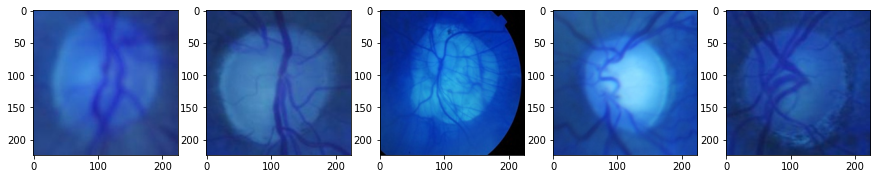

First 5 pictures of the division test/normal of folder Fold0


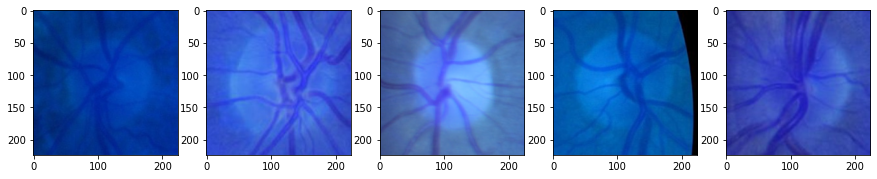

First 5 pictures of the division train/abnormal of folder Fold0


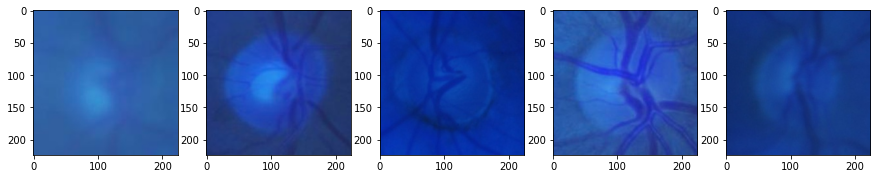

First 5 pictures of the division test/normal of folder Fold0


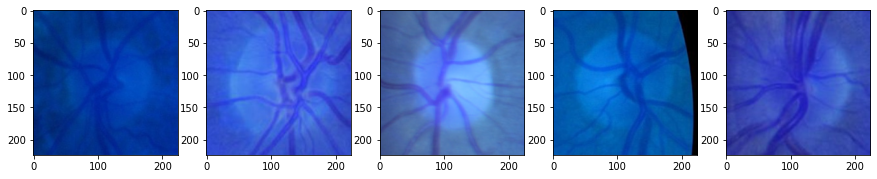

First 5 pictures of the division valid/abnormal of folder Fold0


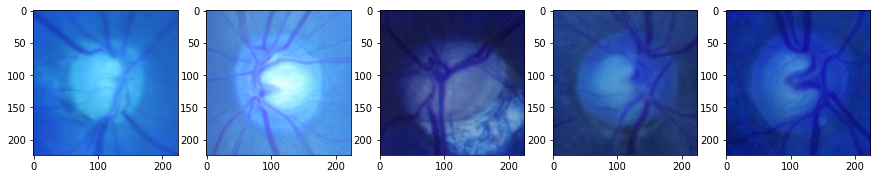

First 5 pictures of the division valid/normal of folder Fold0


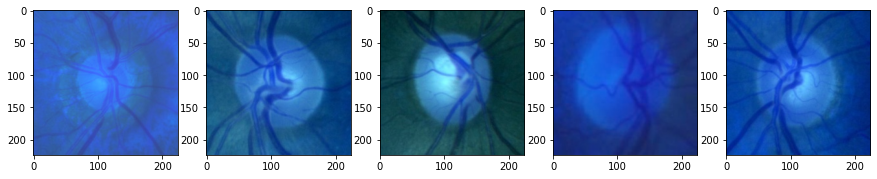

In [ ]:
image_show_5('test/abnormal', 'Fold0')
image_show_5('test/normal', 'Fold0')
image_show_5('train/abnormal', 'Fold0')
image_show_5('test/normal', 'Fold0')
image_show_5('valid/abnormal', 'Fold0')
image_show_5('valid/normal', 'Fold0')

Now, a preparation of the working datasets will be done.

In [ ]:
def dataset_preparation(target_division, folder, seed):
    '''Preparates a set (train or test) specifying a division and folder'''
    return_list = []
    base_path = '/content/drive/MyDrive/practica_DL_UOC_2022'
    target_path_normal = os.path.join(base_path, folder, target_division, 'normal')
    target_path_abnormal = os.path.join(base_path, folder, target_division, 'abnormal')
    # Separates normal from abnormal values
    for item in data[target_path_normal]:
        normal_array = np.array([0,1])
        return_list.append((item, normal_array))
    for item in data[target_path_abnormal]:
        abnormal_array = np.array([1,0])
        return_list.append((item, abnormal_array))
    random.shuffle(return_list)
    return return_list


def features_to_array(set):
    '''Saves the features vector to a numpy array'''
    return_list = []
    for item in set:
        return_list.append(item[0])
    arr = np.array(return_list)
    return arr

    
def labels_to_array(set):
    '''Saves the features vector to a numpy array'''
    return_list = []
    for item in set:
        return_list.append(item[1])
    arr = np.array(return_list)
    return arr


### 2. Network training over a partition



First, using the previous functions, let's work with the first folder only (Fold0).

In [ ]:
train_set = dataset_preparation('train', 'Fold0', [12, 44])
test_set = dataset_preparation('test', 'Fold0', [12, 44])
validation_set = dataset_preparation('valid', 'Fold0', [12, 44])
X_train = features_to_array(train_set)
y_train = labels_to_array(train_set)
X_test = features_to_array(test_set)
y_test = labels_to_array(test_set)
X_valid = features_to_array(validation_set)
y_valid = labels_to_array(validation_set)

After obtaining the data, the first configuration is tried, that is, pre-trained EfficientNetB0 model. It will have Imagenet's weights, and its classification layer will be replaced with a configuration including layers GlobalAveragePooling2D, BatchNormalization, 20% dropout and fully connected.

3 different possibilities with this model will be tried, as it follows:

1. Training of the model freezing every layer except the ones replacing the original classification layer.

2. From model 1's weights, we will unfreeze the last 20 layers. However, BatchNorm layers will be kept frozen. 

3. Finally, the third configuration will train every layer.

In [ ]:
def model_generator_1():
  '''Generates model 1'''
  inputs = keras.layers.Input(shape=(X_train[0].shape))
  base_model = keras.applications.EfficientNetB0(
    weights='imagenet',  
    input_tensor=inputs,
    include_top=False) 
  # Layer freezing
  base_model.trainable = False
  # New layers addition
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(2, activation = 'softmax')(x)
  model1 = keras.Model(inputs, outputs)
  return model1

def f1_metric(y_true, y_pred):
    '''Calculates f1 metric (see [1])'''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def hyper_search(epochs, batches, learning_rates, model_function):
  '''Looks for the ideal hyperparameters for any model'''
  answer = {}
  f1 = 0
  for l in learning_rates:
    opt = tf.keras.optimizers.Adam(learning_rate=l)
    for j in epochs:
      for k in batches:
        model = model_function
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_f1_metric', patience=6)
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
        training = model.fit(X_train, y_train, epochs=j, batch_size = k, validation_data=(X_valid, y_valid), verbose=0, callbacks=[callback])
        compare_f1 = training.history['val_f1_metric'][-1]
        if (float(compare_f1) > float(f1)):
          f1 = compare_f1
          answer['Learning rate'] = l
          answer['Batch size'] = k
          answer['Epochs'] = j
        acc = "{:.3f}".format(training.history['val_accuracy'][-1]) 
        f1_ = "{:.3f}".format(training.history['val_f1_metric'][-1]) 
        print('With learning rate of ' + str(l) + ', ' + str(j) + 
              ' epochs and batch_size of ' + str(k) + ' model yields ' + str(f1_) +
              ' f1-score, ' + str(acc) + ' accuracy. Early stopped @ ' + str(len(training.history['loss'])) + ' epochs.')
  print('Best params: ' + str(answer))



In [ ]:
hyper_search([50], [32], [0.001, 0.0001, 0.00001], model_generator_1())


With learning rate of 0.001, 50 epochs and batch_size of 32 model yields 0.791 f1-score, 0.792 accuracy. Early stopped @ 6 epochs.
With learning rate of 0.0001, 50 epochs and batch_size of 32 model yields 0.838 f1-score, 0.838 accuracy. Early stopped @ 6 epochs.
With learning rate of 1e-05, 50 epochs and batch_size of 32 model yields 0.824 f1-score, 0.825 accuracy. Early stopped @ 12 epochs.
Best params: {'Learning rate': 0.0001, 'Batch size': 32, 'Epochs': 50}


Therefore, the best combination of hyperparameters is: {'Optimizer': 'adam', 'Learning rate': 0.0001, 'Batch size': 32, 'Epochs': 15}. Let's now try the model.

In [ ]:
model1 = model_generator_1()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
training_1 = model1.fit(X_train, y_train, epochs=15, batch_size = 32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/15
44/44 [==============================] - 10s 99ms/step - loss: 0.9954 - accuracy: 0.5228 - f1_metric: 0.5121 - val_loss: 0.6612 - val_accuracy: 0.5974 - val_f1_metric: 0.5952
Epoch 2/15
44/44 [==============================] - 3s 66ms/step - loss: 0.7638 - accuracy: 0.6309 - f1_metric: 0.6385 - val_loss: 0.6196 - val_accuracy: 0.6494 - val_f1_metric: 0.6437
Epoch 3/15
44/44 [==============================] - 3s 67ms/step - loss: 0.7113 - accuracy: 0.6519 - f1_metric: 0.6522 - val_loss: 0.5887 - val_accuracy: 0.6429 - val_f1_metric: 0.6375
Epoch 4/15
44/44 [==============================] - 3s 67ms/step - loss: 0.6531 - accuracy: 0.6809 - f1_metric: 0.6875 - val_loss: 0.5605 - val_accuracy: 0.6883 - val_f1_metric: 0.6827
Epoch 5/15
44/44 [==============================] - 3s 67ms/step - loss: 0.5871 - accuracy: 0.7201 - f1_metric: 0.7259 - val_loss: 0.5406 - val_accuracy: 0.7013 - val_f1_metric: 0.6966
Epoch 6/15
44/44 [==============================] - 3s 67ms/step - loss: 0

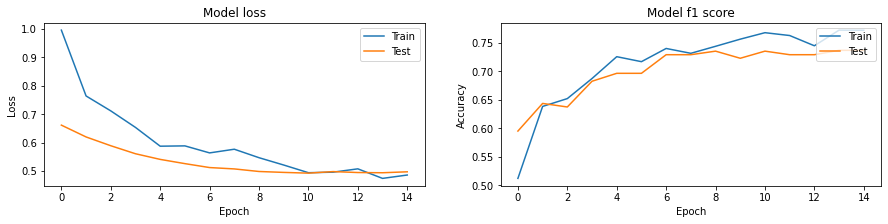

In [ ]:
def plot_model(training):
  ''Plot each model's loss and f1-score'''

  fig, axs = plt.subplots(1, 2, figsize=(15, 3), sharey=False)

  axs[0].plot(training.history['loss'])
  axs[0].plot(training.history['val_loss'])
  axs[0].title.set_text('Model loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Test'], loc='upper right')

  axs[1].plot(training.history['f1_metric'])
  axs[1].plot(training.history['val_f1_metric'])
  axs[1].title.set_text('Model f1 score')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Test'], loc='upper right')

  plt.show()

plot_model(training_1)

In [ ]:
# Dict to store metrics from every model
global_metrics = {}


def matrix_generator(model):
  '''Generates the confusion matrix for each model'''
  pred = model.predict(X_test)
  pred1 = pred
  y_test_ = []
  y_pred_ = []
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  #Logic: 0-normal, 1-abnormal
  for i in range(0, len(pred)):
    for j in range(0, 2):
      if (pred[i][j] > 0.5):
        pred1[i][j] = 1
      else:
        pred1[i][j] = 0
  for k in range(0, len(pred1)):
    if (pred1[k][0] == 0):
      y_pred_.append(0)
    else:
      y_pred_.append(1)
  for k in range(0, len(y_test)):
    if (y_test[k][0] == 0):
      y_test_.append(0)
    else:
      y_test_.append(1)
  for l in range(0, len(y_test_)):
    if (y_test_[l] == 1 and y_pred_[l] == 1):
      tp += 1
    if (y_test_[l] == 1 and y_pred_[l] == 0):
      fn += 1
    if (y_test_[l] == 0 and y_pred_[l] == 0):
      tn += 1
    if (y_test_[l] == 0 and y_pred_[l] == 1):
      fp += 1
  return [[tp, fp], [fn, tn]]

def matrix_metrics(model, model_name):
  '''Generates the matrix's metrics and plots it'''
  matrix = matrix_generator(model)
  title = 'Confusion matrix ' + model_name
  tp = matrix[0][0] 
  fp = matrix[0][1]
  fn = matrix[1][0]
  tn = matrix[1][1]
  sensitivity = tp/(tp + fn)
  specificity = tn/(fp + tn)
  precision = tp/(tp + fp)
  accuracy = (tp + tn)/(tp + fp + fn + tn)
  f1_score = 2*tp/(2*tp + fp + fn)
  metrics = pd.DataFrame([[sensitivity, specificity, precision, accuracy, f1_score]],columns=['sensitivity','specificity','precision', 'accuracy', 'f1_score'])
  print(metrics)
  ax = sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
  ax.set_title(title);
  ax.set_xlabel('\nReal')
  ax.set_ylabel('Prediccion');
  ax.xaxis.set_ticklabels(['Glaucoma','Sano'])
  ax.yaxis.set_ticklabels(['Glaucoma','Sano'])
  plt.show()
  global_metrics[model_name] = [[matrix], [sensitivity, specificity, precision, accuracy, f1_score]]


   sensitivity  specificity  precision  accuracy  f1_score
0     0.641304     0.926829   0.907692  0.775862  0.751592


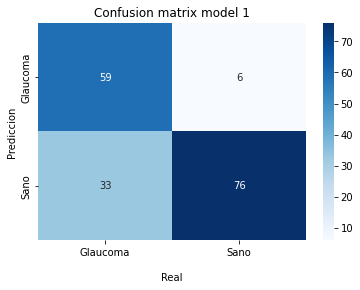

In [ ]:
matrix_metrics(model1, 'model 1')

We'll now reproduce the same steps with model 2.

In [ ]:
def model_generator_2():
  '''Generates model 2'''
  model = model_generator_1()
  for layer in model.layers[-20:]:
    if (isinstance(layer, keras.layers.BatchNormalization) == False):
      layer.trainable = True
    else:
      layer.trainable = False
  model.set_weights(model1.get_weights())
  return model 


In [ ]:
hyper_search([20], [32], [0.001, 0.0001, 0.00001], model_generator_2())


With learning rate of 0.001, 20 epochs and batch_size of 32 model yields 0.841 f1-score, 0.844 accuracy. Early stopped @ 8 epochs.
With learning rate of 0.0001, 20 epochs and batch_size of 32 model yields 0.868 f1-score, 0.870 accuracy. Early stopped @ 6 epochs.
With learning rate of 1e-05, 20 epochs and batch_size of 32 model yields 0.875 f1-score, 0.877 accuracy. Early stopped @ 6 epochs.
Best params: {'Learning rate': 1e-05, 'Batch size': 32, 'Epochs': 20}


Best parameters are {'Learning rate': 0.00001, 'Batch size': 32, 'Epochs': 8}.

In [ ]:
model2 = model_generator_2()

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
training_2 = model2.fit(X_train, y_train, epochs=8, batch_size = 32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/8
44/44 [==============================] - 10s 105ms/step - loss: 0.4366 - accuracy: 0.7999 - f1_metric: 0.7971 - val_loss: 0.4863 - val_accuracy: 0.7403 - val_f1_metric: 0.7356
Epoch 2/8
44/44 [==============================] - 3s 72ms/step - loss: 0.4597 - accuracy: 0.7854 - f1_metric: 0.7760 - val_loss: 0.4729 - val_accuracy: 0.7532 - val_f1_metric: 0.7510
Epoch 3/8
44/44 [==============================] - 3s 73ms/step - loss: 0.4681 - accuracy: 0.7890 - f1_metric: 0.7865 - val_loss: 0.4700 - val_accuracy: 0.7532 - val_f1_metric: 0.7510
Epoch 4/8
44/44 [==============================] - 3s 73ms/step - loss: 0.4112 - accuracy: 0.8165 - f1_metric: 0.8203 - val_loss: 0.4580 - val_accuracy: 0.7597 - val_f1_metric: 0.7587
Epoch 5/8
44/44 [==============================] - 3s 73ms/step - loss: 0.4353 - accuracy: 0.7962 - f1_metric: 0.8004 - val_loss: 0.4661 - val_accuracy: 0.7597 - val_f1_metric: 0.7572
Epoch 6/8
44/44 [==============================] - 3s 73ms/step - loss: 0.4132

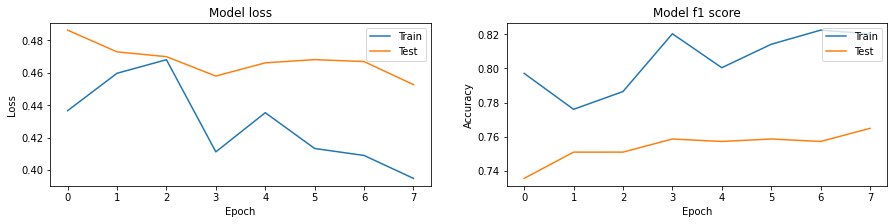

In [ ]:
plot_model(training_2)

   sensitivity  specificity  precision  accuracy  f1_score
0     0.717391     0.939024   0.929577  0.821839  0.809816


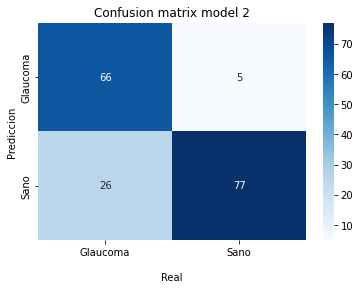

In [ ]:
matrix_metrics(model2, 'model 2')

Let's work with model 3 now.


In [ ]:
def model_generator_3():
  '''Generates model 3'''
  model = model_generator_2()
  model.trainable = True 
  model.set_weights(model2.get_weights())
  return model 

In [ ]:
hyper_search([20], [32], [0.001, 0.0001, 0.00001], model_generator_3())

With learning rate of 0.001, 20 epochs and batch_size of 32 model yields 0.807 f1-score, 0.812 accuracy. Early stopped @ 11 epochs.
With learning rate of 0.0001, 20 epochs and batch_size of 32 model yields 0.910 f1-score, 0.909 accuracy. Early stopped @ 7 epochs.
With learning rate of 1e-05, 20 epochs and batch_size of 32 model yields 0.902 f1-score, 0.903 accuracy. Early stopped @ 7 epochs.
Best params: {'Learning rate': 0.0001, 'Batch size': 32, 'Epochs': 20}


Best config is: {'Learning rate': 0.0001, 
'Batch size': 32, 'Epochs': 20}.




In [ ]:
model3 = model_generator_3()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
training_3 = model3.fit(X_train, y_train, epochs=20, batch_size = 32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
44/44 [==============================] - 23s 335ms/step - loss: 0.5963 - accuracy: 0.7346 - f1_metric: 0.7401 - val_loss: 1.9144 - val_accuracy: 0.4610 - val_f1_metric: 0.4611
Epoch 2/20
44/44 [==============================] - 13s 299ms/step - loss: 0.2817 - accuracy: 0.8811 - f1_metric: 0.8767 - val_loss: 1.2804 - val_accuracy: 0.4610 - val_f1_metric: 0.4611
Epoch 3/20
44/44 [==============================] - 13s 300ms/step - loss: 0.1820 - accuracy: 0.9311 - f1_metric: 0.9325 - val_loss: 1.0549 - val_accuracy: 0.4481 - val_f1_metric: 0.4486
Epoch 4/20
44/44 [==============================] - 13s 300ms/step - loss: 0.1066 - accuracy: 0.9659 - f1_metric: 0.9666 - val_loss: 1.5385 - val_accuracy: 0.4675 - val_f1_metric: 0.4659
Epoch 5/20
44/44 [==============================] - 13s 300ms/step - loss: 0.0962 - accuracy: 0.9587 - f1_metric: 0.9458 - val_loss: 1.4417 - val_accuracy: 0.4740 - val_f1_metric: 0.4764
Epoch 6/20
44/44 [==============================] - 13s 301ms/ste

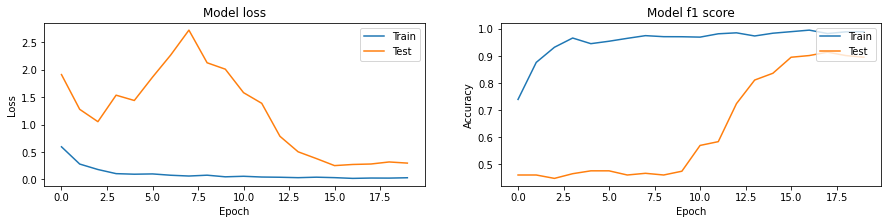

In [ ]:
plot_model(training_3)

   sensitivity  specificity  precision  accuracy  f1_score
0     0.902174     0.926829   0.932584  0.913793  0.917127


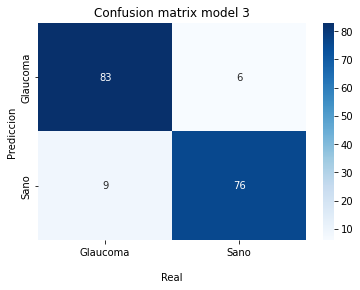

In [ ]:
matrix_metrics(model3, 'model 3')

I'll try now two completely different models that should also give a good result with this problem. These are:

4.   VGG16
5.   ResNet50



In [ ]:
def model_generator_4():
  '''Generates model 4'''
  base_model = keras.applications.VGG16(
    input_shape = X_train[0].shape,
    include_top=False)
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(2, activation = 'softmax')(x)
  model1 = keras.Model(base_model.inputs, outputs)
  return model1 



In [ ]:
hyper_search([20], [32], [0.0001, 0.00001], model_generator_4())

With learning rate of 0.0001, 20 epochs and batch_size of 32 model yields 0.839 f1-score, 0.838 accuracy. Early stopped @ 20 epochs.
With learning rate of 1e-05, 20 epochs and batch_size of 32 model yields 0.871 f1-score, 0.877 accuracy. Early stopped @ 19 epochs.
Best params: {'Learning rate': 1e-05, 'Batch size': 32, 'Epochs': 20}


In [ ]:
model4 = model_generator_4()
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
training_4 = model4.fit(X_train, y_train, epochs=20, batch_size = 32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/20
44/44 [==============================] - 20s 440ms/step - loss: 0.6842 - accuracy: 0.6831 - f1_metric: 0.6690 - val_loss: 0.5918 - val_accuracy: 0.7922 - val_f1_metric: 0.7899
Epoch 2/20
44/44 [==============================] - 20s 447ms/step - loss: 0.3573 - accuracy: 0.8368 - f1_metric: 0.8333 - val_loss: 0.6153 - val_accuracy: 0.7857 - val_f1_metric: 0.7837
Epoch 3/20
44/44 [==============================] - 19s 438ms/step - loss: 0.2596 - accuracy: 0.8883 - f1_metric: 0.8906 - val_loss: 0.4810 - val_accuracy: 0.8052 - val_f1_metric: 0.8024
Epoch 4/20
44/44 [==============================] - 19s 435ms/step - loss: 0.1866 - accuracy: 0.9246 - f1_metric: 0.9261 - val_loss: 0.4312 - val_accuracy: 0.7987 - val_f1_metric: 0.7976
Epoch 5/20
44/44 [==============================] - 19s 435ms/step - loss: 0.1423 - accuracy: 0.9550 - f1_metric: 0.9560 - val_loss: 0.5724 - val_accuracy: 0.7857 - val_f1_metric: 0.7837
Epoch 6/20
44/44 [==============================] - 19s 438ms/ste

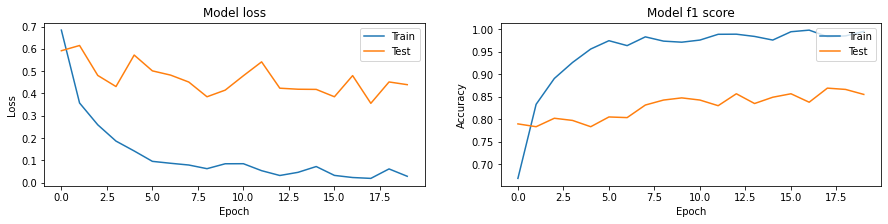

In [ ]:
plot_model(training_4)

   sensitivity  specificity  precision  accuracy  f1_score
0      0.73913     0.963415   0.957746  0.844828  0.834356


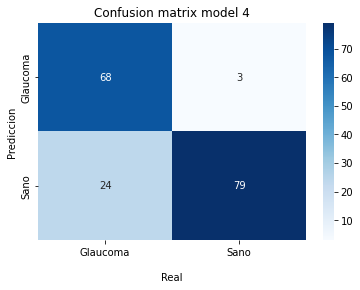

In [ ]:
matrix_metrics(model4, 'model 4')

In [ ]:
def model_generator_5():
  '''Generates model 5'''
  base_model = keras.applications.ResNet50(
    input_shape = X_train[0].shape,
    include_top=False)
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(2, activation = 'softmax')(x)
  model1 = keras.Model(base_model.inputs, outputs)
  return model1 

In [ ]:
hyper_search([20], [32], [0.0001, 0.00001], model_generator_5())

94781440/94765736 [==============================] - 3s 0us/step
With learning rate of 0.0001, 20 epochs and batch_size of 32 model yields 0.888 f1-score, 0.890 accuracy. Early stopped @ 11 epochs.
With learning rate of 1e-05, 20 epochs and batch_size of 32 model yields 0.897 f1-score, 0.896 accuracy. Early stopped @ 11 epochs.
Best params: {'Learning rate': 1e-05, 'Batch size': 32, 'Epochs': 20}


In [ ]:
model5 = model_generator_5()
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
training_5 = model5.fit(X_train, y_train, epochs=12, batch_size = 32, validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/12
44/44 [==============================] - 20s 331ms/step - loss: 0.7585 - accuracy: 0.6657 - f1_metric: 0.6657 - val_loss: 0.6629 - val_accuracy: 0.6039 - val_f1_metric: 0.6043
Epoch 2/12
44/44 [==============================] - 14s 309ms/step - loss: 0.3208 - accuracy: 0.8738 - f1_metric: 0.8764 - val_loss: 0.6427 - val_accuracy: 0.6234 - val_f1_metric: 0.6288
Epoch 3/12
44/44 [==============================] - 14s 311ms/step - loss: 0.1885 - accuracy: 0.9217 - f1_metric: 0.9164 - val_loss: 0.5916 - val_accuracy: 0.7143 - val_f1_metric: 0.7149
Epoch 4/12
44/44 [==============================] - 14s 314ms/step - loss: 0.1399 - accuracy: 0.9471 - f1_metric: 0.9344 - val_loss: 0.4739 - val_accuracy: 0.7468 - val_f1_metric: 0.7505
Epoch 5/12
44/44 [==============================] - 14s 319ms/step - loss: 0.0881 - accuracy: 0.9746 - f1_metric: 0.9751 - val_loss: 0.4165 - val_accuracy: 0.7922 - val_f1_metric: 0.7942
Epoch 6/12
44/44 [==============================] - 14s 321ms/ste

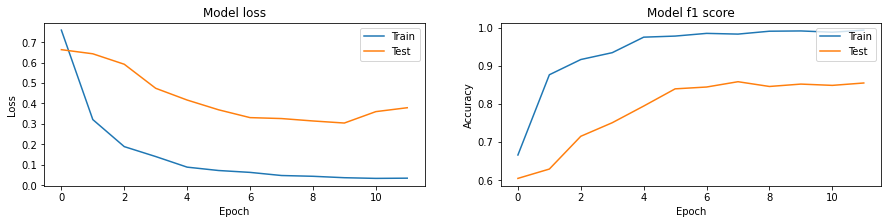

In [ ]:
plot_model(training_5)

   sensitivity  specificity  precision  accuracy  f1_score
0     0.804348     0.902439   0.902439  0.850575  0.850575


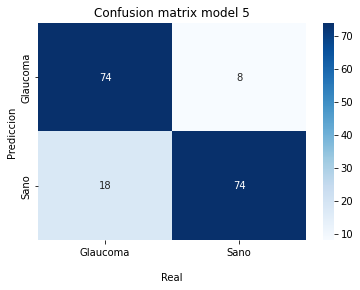

In [ ]:
matrix_metrics(model5, 'model 5')

We'll now compare scores from the different models we have tried.

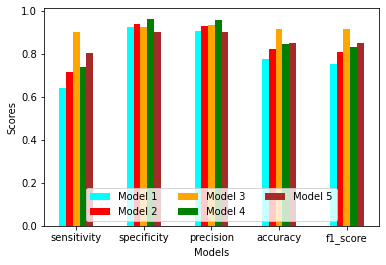

In [ ]:
x = np.arange(5)
y1 = global_metrics['model 1'][1]
y2 = global_metrics['model 2'][1]
y3 = global_metrics['model 3'][1]
y4 = global_metrics['model 4'][1]
y5 = global_metrics['model 5'][1]
width = 0.1
  
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x-0.1, y2, width, color='red')
plt.bar(x, y3, width, color='orange')
plt.bar(x+0.1, y4, width, color='green')
plt.bar(x+0.2, y5, width, color='brown')
plt.xticks(x, ['sensitivity','specificity','precision', 'accuracy', 'f1_score'])
plt.xlabel("Models")
plt.ylabel("Scores")
plt.legend(["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"], loc='lower center', ncol = 3)
plt.show()

# 3. Cross validation

Taking the model that yields the best f1-score, we'll now try to see how it works with the whole set of folders.

In [ ]:
def fold_generator(foldname, seed):
  '''Expands the data generation to the whole set of folders'''
  return_dict = {}
  train_set = dataset_preparation('train', foldname, seed)
  test_set = dataset_preparation('test', foldname, seed)
  validation_set = dataset_preparation('valid', foldname, seed)
  return_dict[foldname + '_X_train_set'] = features_to_array(train_set)
  return_dict[foldname + '_y_train_set'] = labels_to_array(train_set)
  return_dict[foldname + '_X_test_set'] = features_to_array(test_set)
  return_dict[foldname + '_y_test_set'] = labels_to_array(test_set)
  return_dict[foldname + '_X_valid_set'] = features_to_array(validation_set)
  return_dict[foldname + '_y_valid_set'] = labels_to_array(validation_set)
  return return_dict


In [ ]:
def model_generator_6():
  '''Generates a model fit for cross-validation'''
  inputs = keras.layers.Input(shape=(X_train[0].shape))
  base_model = keras.applications.EfficientNetB0(
    weights='imagenet',  
    input_tensor=inputs,
    include_top=False) 
  # Layer freezing
  base_model.trainable = False
  # New layer addition
  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(2, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)
  for layer in model.layers[-20:]:
    if (isinstance(layer, keras.layers.BatchNormalization) == False):
      layer.trainable = True
    else:
      layer.trainable = False
  return model


In [ ]:
def fold_train():
  '''Trains each folder, and gets its confusion matrix'''
  seed = [13, 34]
  for i in range(10):
    foldname = 'Fold' + str(i)
    generated = fold_generator(foldname, seed)
    X_train = generated[foldname + '_X_train_set']
    y_train = generated[foldname + '_y_train_set']
    X_test = generated[foldname + '_X_test_set']
    y_test = generated[foldname + '_y_test_set']
    X_valid = generated[foldname + '_X_valid_set']
    y_valid = generated[foldname + '_y_valid_set']
    model = model_generator_6()
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', f1_metric])
    training = model.fit(X_train, y_train, epochs=20, batch_size = 32, validation_data=(X_valid, y_valid), verbose=0)
    acc = "{:.3f}".format(training.history['val_accuracy'][-1]) 
    f1_ = "{:.3f}".format(training.history['val_f1_metric'][-1]) 
    print('Folder: ' + foldname + ', accuracy of ' + acc + ', f1 score of ' + f1_ + '.')
    matrix_metrics(model, foldname)
    for j in range(2):
      seed[j] += 17



Folder: Fold0, accuracy of 0.799, f1 score of 0.799.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.630435     0.914634   0.892308  0.764368  0.738854


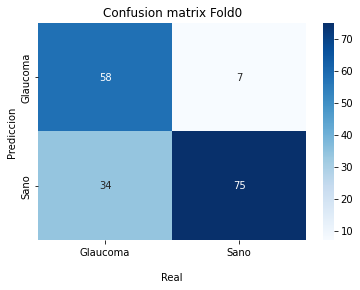

Folder: Fold1, accuracy of 0.857, f1 score of 0.860.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.771739     0.890244     0.8875  0.827586  0.825581


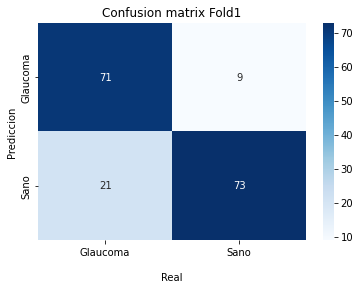

Folder: Fold2, accuracy of 0.857, f1 score of 0.857.
   sensitivity  specificity  precision  accuracy  f1_score
0         0.75     0.890244   0.884615  0.816092  0.811765


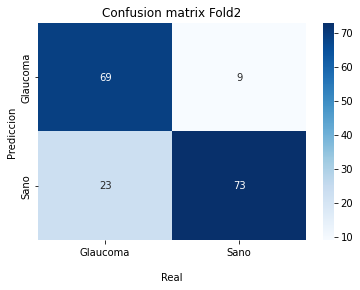

Folder: Fold3, accuracy of 0.825, f1 score of 0.821.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.771739     0.914634   0.910256   0.83908  0.835294


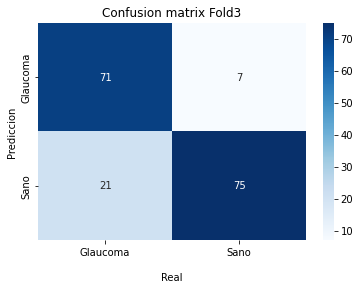

Folder: Fold4, accuracy of 0.786, f1 score of 0.785.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.717391     0.926829   0.916667  0.816092  0.804878


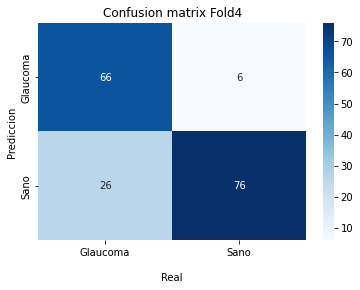

Folder: Fold5, accuracy of 0.786, f1 score of 0.778.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.684783     0.926829   0.913043  0.798851  0.782609


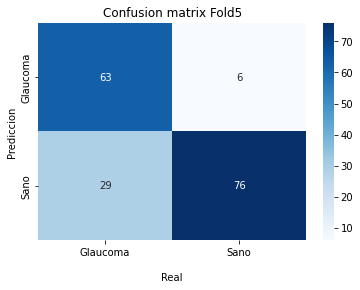

Folder: Fold6, accuracy of 0.844, f1 score of 0.844.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.728261     0.914634   0.905405  0.816092  0.807229


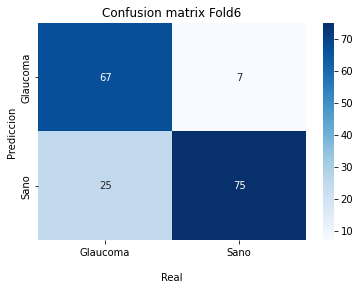

Folder: Fold7, accuracy of 0.812, f1 score of 0.812.
   sensitivity  specificity  precision  accuracy  f1_score
0      0.76087     0.902439   0.897436  0.827586  0.823529


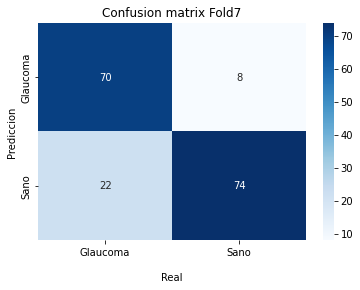

Folder: Fold8, accuracy of 0.805, f1 score of 0.802.
   sensitivity  specificity  precision  accuracy  f1_score
0      0.76087     0.865854   0.864198  0.810345  0.809249


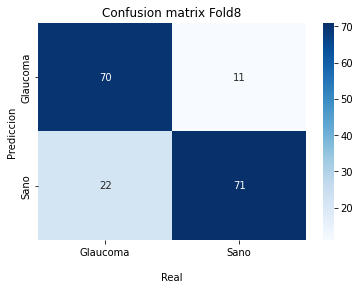

Folder: Fold9, accuracy of 0.760, f1 score of 0.757.
   sensitivity  specificity  precision  accuracy  f1_score
0     0.684783     0.939024   0.926471  0.804598    0.7875


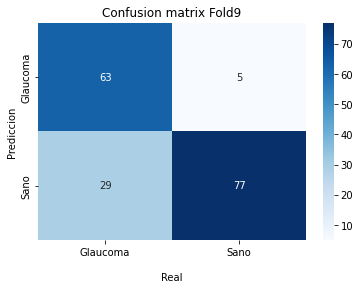

In [ ]:
fold_train()

It's time to check the results

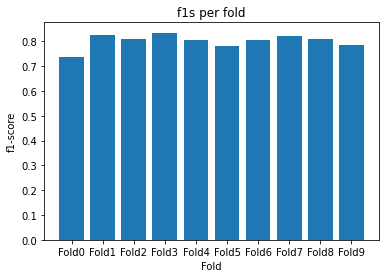

In [ ]:
f1s = []
labels = []
for i in range(10):
  foldname = 'Fold' + str(i)
  f1s.append(global_metrics[foldname][1][4])
  labels.append(foldname)

plot = plt.bar(labels, f1s)

plt.title("f1s per fold")
plt.xlabel("Fold")
plt.ylabel("f1-score")

plt.show()